# Text Clustering

This week we will be clustering documents. Clustering documents can be used to find commonalities or themes in our texts. For this assignment, our documents will consist of tweets on healthcare news from the `Health News in Twitter` dataset on the UCI Machine Learning Repository (Karami, 2017). This data was collected in 2015 using Twitter API and contains health news from more than 15 major health news agencies such as BBC, CNN, and NYT (Karami, 2017). The goal is to try and understand some of the general topics being tweeted about in our documents using clustering.

## Load Tweets from `Health News in Twitter` Data Set

To read all the files from the `Health News in Twitter` dataset into a dataframe, we need to loop through the files using `iglob()`. The `glob` module is used to retrieve files/pathnames matching a specified pattern (How to use Glob() function, 2019). After looping through the files with `iglob()`, we need to add them to a list. Then, we we can use the `pd.concat()` function, which allows us to combine datasets from our list (Combining datasets, n.d). Some of the lines in the files have extra `|` symbols in the tweets, which can cause issues when parsing the file since `|` is also the delimiter in the file. We can add the argument `error_bad_lines=False` when we read the files which will skip the lines with extra `|` symbols. We will also add the `encoding` argument to improves special character handling.

In [1]:
from glob import iglob

In [2]:
iglob("C:/Users/07hoc/Downloads/MSDS 682 Downloads/Week 5/Health-Tweets/*.txt")

<generator object _iglob at 0x00000224A70BDE48>

In [3]:
num_docs = len(list(iglob("C:/Users/07hoc/Downloads/MSDS 682 Downloads/Week 5/Health-Tweets/*.txt")))

In [4]:
# get first file in folder
print("There are", num_docs, "health news documents.\n")
print("The first document is:", list(iglob("C:/Users/07hoc/Downloads/MSDS 682 Downloads/Week 5/Health-Tweets/*.txt"))[0])

There are 16 health news documents.

The first document is: C:/Users/07hoc/Downloads/MSDS 682 Downloads/Week 5/Health-Tweets\bbchealth.txt


In [5]:
dfs = [] #use pandas to create a list of dataframes

In [6]:
import time #count the number of seconds that have passed

In [7]:
start = time.time()

import pandas as pd
for file in iglob("C:/Users/07hoc/Downloads/MSDS 682 Downloads/Week 5/Health-Tweets/*.txt"):
    dfs.append(pd.read_csv(file,
                       sep='|',
                       header=None,
                       error_bad_lines=False,
                       encoding='latin-1')) #could also use encoding='ISO-8859-1' 

end = time.time()
print('Process took', int(round(end - start)), 'seconds.')    

Process took 1 seconds.


b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, saw 4\nSkipping line 1710: expected 3 fields, saw 4\nSkipping line 2699: expected 3 fields, saw 4\nSkipping line 2728: expected 3 fields, saw 4\nSkipping line 3000: expected 3 fields, saw 4\n'
b'Skipping line 1422: expected 3 fields, saw 4\nSkipping line 1461: expected 3 fields, saw 4\nSkipping line 1468: expected 3 fields, saw 4\nSkipping line 1507: expected 3 fields, saw 4\nSkipping line 1547: expected 3 fields, saw 4\nSkipping line 1728: expected 3 fields, saw 4\nSkipping line 1738: expected 3 fields, saw 4\nSkipping line 1742: expected 3 fields, saw 4\nSkipping line 1847: expected 3 

In [8]:
len(dfs)

16

In [152]:
type(dfs), type(dfs[0])

(list, pandas.core.frame.DataFrame)

The "red field" above tells us that we are skipping lines. The lines that are being skipped are the lines with extra `|` symbols (`error_bad_lines=False`). Now that we have a list containing dataframes for each of our documents, we can use the `pd.concat()` function to combine these dataframes into a single dataframe, which we will define as `tweet_df`.

In [9]:
tweet_df = pd.concat(dfs) #concat list of dataframes

In [10]:
tweet_df.shape #we have about 62,000 tweets

(62817, 3)

In [11]:
tweet_df.head()

,0,1,2
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/...
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc...
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc...
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bb...
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bb...


To make the columns in our `tweet_df` more easily accessible, we can change the columns names. 

In [12]:
tweet_df.columns = ['Id', 'Datetime', 'Tweets'] #change column names

In [13]:
tweet_df.columns

Index(['Id', 'Datetime', 'Tweets'], dtype='object')

## Clean Text

### Clean Text using Regex: Remove Web Links, Usernames, Hashtags

We will use the `re` library in Python to remove web links, which contain `http://` or `https://`. First, we need to view the tweets in our dataframe, so we can access them later. To do this, the `iloc[]` function is used, which gets rows or columns by using positions (integers) (Arora, 2020). 

In [14]:
tweet_df['Tweets'].iloc[0:10]

0    Breast cancer risk test devised http://bbc.in/...
1    GP workload harming care - BMA poll http://bbc...
2    Short people's 'heart risk greater' http://bbc...
3    New approach against HIV 'promising' http://bb...
4    Coalition 'undermined NHS' - doctors http://bb...
5    Review of case against NHS manager http://bbc....
6    VIDEO: 'All day is empty, what am I going to d...
7    VIDEO: 'Overhaul needed' for end-of-life care ...
8    Care for dying 'needs overhaul' http://bbc.in/...
9    VIDEO: NHS: Labour and Tory key policies http:...
Name: Tweets, dtype: object

Now that we can access the tweets in our dataframe, we can use the `re` module and the `re.sub` function to remove web links, usernames, and hashtags. To do this, we define a pattern we want to remove, and then we define a string to replace the defined pattern. 

In [15]:
import re

In [16]:
#remove http://, \S is anything that is not a space
no_html_tweets = tweet_df['Tweets'].apply(lambda x: re.sub('http://\S+', '', x))

In [17]:
no_html_tweets.iloc[0:10]

0                     Breast cancer risk test devised 
1                 GP workload harming care - BMA poll 
2                 Short people's 'heart risk greater' 
3                New approach against HIV 'promising' 
4                Coalition 'undermined NHS' - doctors 
5                  Review of case against NHS manager 
6    VIDEO: 'All day is empty, what am I going to d...
7       VIDEO: 'Overhaul needed' for end-of-life care 
8                     Care for dying 'needs overhaul' 
9            VIDEO: NHS: Labour and Tory key policies 
Name: Tweets, dtype: object

In [18]:
#remove https
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('https://\S+', '', x))

In [19]:
#remove @usernames
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('@\S+', '', x))

In [20]:
#remove #hashtags
no_html_tweets = no_html_tweets.apply(lambda x: re.sub('#\S+', '', x))

In [21]:
no_html_tweets.iloc[0:10]

0                     Breast cancer risk test devised 
1                 GP workload harming care - BMA poll 
2                 Short people's 'heart risk greater' 
3                New approach against HIV 'promising' 
4                Coalition 'undermined NHS' - doctors 
5                  Review of case against NHS manager 
6    VIDEO: 'All day is empty, what am I going to d...
7       VIDEO: 'Overhaul needed' for end-of-life care 
8                     Care for dying 'needs overhaul' 
9            VIDEO: NHS: Labour and Tory key policies 
Name: Tweets, dtype: object

In [22]:
# #get rid of weird characters x
# clean_tweets[0:-1][10]

In [23]:
# print(clean_tweets[0:20][10].encode('utf-8').decode('utf-8'))

In [24]:
# no_html_tweets[:20][10].encode('ascii', 'ignore').decode('ascii')

### Clean Text using Text Cleaning Function

A few common twitter-related words include RT, mention, reply, DM, Follower, and Hashtag. A RT (retweet) allows a user to share a tweet, a mention allows a user to tag another user using the `@` sign, reply allows a user to reply to a single user using the `@` sign, a DM (Direct Message) is a private message, a follower is someone use follows a user on Twitter, and a Hashtag uses the `#` symbol in front of a word or phrase so a user can tag their tweets. Thus, we will want to add these words to a stopword list.

In [25]:
import spacy
nlp = spacy.load('en_core_web_lg')
import nltk

In [26]:
stopwords = nltk.corpus.stopwords.words('english')

In [27]:
stopwords[0:10] #view 10 stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
stopwords = set(stopwords + ['RT', 'health', 'healthcare', 'DM', 'retweet',
                             'direct message', 'reply', 'following', 'followers', 
                             'mention', 'hashtag']) 
#adds to list of stopwords above and keep as set() (Set() method, 2018)

In [29]:
import string #to remove punct and digits

In [30]:
# simple clean text function -- spacy lowercases, removes stopwords, lemmatizes
    #function from Week 5 Starter
def clean_text(docs):
    # remove punctuation and numbers
    # I do this before lemmatizing, so things like "act's" turn into 'act' instead of 'act s'
    print('removing punctuation and digits')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [d.translate(table) for d in docs]
    
    print('spacy nlp...longest part')
    nlp_docs = [nlp(d) for d in clean_docs]
    
    # keep the word if it's a pronoun, otherwise use the lemma
    # otherwise spacy substitutes '-PRON-' for pronouns
    print('getting lemmas')
    lemmatized_docs = [[w.lemma_ if w.lemma_ != '-PRON-'
                           else w.lower_
                           for w in d]
                      for d in nlp_docs]
    
    # remove stopwords
    print('removing stopwords')
    lemmatized_docs = [[lemma for lemma in doc if lemma not in stopwords] for doc in lemmatized_docs] 

        #remove specific stop words
    
    # join tokens back into doc (string) because lemmatized_docs is a list
    clean_docs = [' '.join(l) for l in lemmatized_docs] #join tweets in a string
        
    return clean_docs

Now that we have used the `re` module to perform a few substitutions and we have our `clean_text` function defined, we can clean our documents. We will use our `no_html_tweets` which contains the tweets that we performed the substitutions on. We will use the `time.time()` function to time our process (Python time Module, n.d). 

In [31]:
start = time.time()
clean_tweets = clean_text(no_html_tweets)
end = time.time()
print('Process took', int(round(end - start)), 'seconds')

removing punctuation and digits
spacy nlp...longest part
getting lemmas
removing stopwords
Process took 350 seconds


In [32]:
clean_tweets[0:10]

['breast cancer risk test devise',
 'gp workload harm care   BMA poll',
 'short people heart risk great',
 'new approach HIV promise',
 'Coalition undermine NHS   doctor',
 'review case NHS manager',
 'video day empty go',
 'video overhaul need endoflife care',
 'care die need overhaul',
 'VIDEO NHS Labour Tory key policy']

## Create TfIdf Vectors (Features)

Using our `clean_tweets` variable above, we can import the `TfidfVectorizer` from `sklearn` to convert the collection of raw documents to a matrix of TF-IDF features (Feature_extraction. Text. Tfidfvectorizer, n.d.). After me import this module, we can create our vectorizer and then we can use the vectorizer to fit and transform our `clean_tweets`. We will use the argument `min_df=10` to that we ignore terms that have a document frequency lower than 10 (Feature_extraction. Text. Tfidfvectorizer, n.d.).

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer(min_df=10) #min number of tweets (min doc freq)
features = vectorizer.fit_transform(clean_tweets)
type(features)

scipy.sparse.csr.csr_matrix

In [35]:
features.shape

(62817, 4717)

In [36]:
#convert matrix to numpy dense matrix
features = features.todense()

## Clustering: K-means

The K-means clustering algorithm is an unsupervised machine learning algorithm. "Unsupervised algorithms make inferences from data using input vectors without referring to known outcomes (Garbade, 2018)." The K-means algorithm tries to partition the dataset into `K` pre-defined clusters (subgroups/centroids) where each data point belongs to one group (Dabbura, 2020). A centroid is the location that represents the center of the cluster (Garbade, 2018). The algorithm tries to make the intra-cluster points as similar as possible while keeping the clusters as different as possible (Dabbura, 2020). Data points are assigned to a cluster where the sum of the squared distance between the data points and the cluster's centroid (mean of all data points that belong to that cluster) is at the minimum (Dabbura, 2020). 

To use the K-means clustering algorithm, we need to import `KMeans` from `sklearn` and then we can create and fit our model (Cluster. Kmeans, n.d.). The arguments we will be using in our model are (Cluster. Kmeans, n.d.):
1. n_clusters: The number of clusters to form as well as the number of centroids to generate.
2. random_state: Determines random number generation for centroid initialization. 
3. n_jobs: The number of OpenMP threads to use for the computation. `None` or `-1` means using all processors. 

Setting `n_jobs = -1` allows us to use all the processors on our machine which makes the computations faster. 

In [37]:
from sklearn.cluster import KMeans

In [38]:
# make a model
model = KMeans(n_clusters = 30, random_state=42, n_jobs = -1)

In [39]:
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### Find the Best Number of Clusters

Now, we need  use a scoring metric to get the optimal number of clusters. We will use the `within sum of squares (WSS)`, which is the sum of squared distances between the points and their cluster centers. We will then plot our WSS against the number of clusters (`n_clusters`) with a scatter plot. This plot is often referred to as a `Scree Plot` because of its resemblance to a slope covered with loose stones (scree). The ideal Scree Plot will have an "elbow" where the quality measure improves more slowly as the number of clusters increases (Selecting number of clusters, n.d.). In other words, the elbow is where the quality of the model is no longer improving and it indicates the best number of clusters for our data. To get our within sum of squares, we need to loop through a set range of clusters using the `range()` function. Then we will want to create a model and fit the model for each number of clusters. Then, we will append the `.score` of the features to a list. 

In [41]:
wss = []
#(within sum of squares)
for n in range(2,20):
    print(n)
    model = KMeans(n_clusters = n, random_state=42, n_jobs = -1)
    model.fit(features)
    wss.append(-model.score(features))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [153]:
wss #view scores

[62154.97387305419,
 61955.80658952549,
 61806.58136622164,
 61635.60990693347,
 61508.97691147585,
 61328.329286555025,
 61237.022804177934,
 61132.62836276817,
 60928.355051085724,
 60858.611485328074,
 60746.11635065753,
 60658.67978325991,
 60557.126632916006,
 60446.24420303857,
 60368.20333294471,
 60251.68665331371,
 60158.08774137572,
 60082.41323245973]

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 
#inline: plot shows automatically

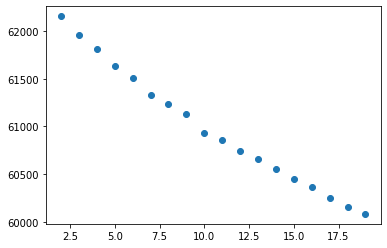

In [44]:
plt.scatter(range(2, 20), wss)

There doesn't seem to be a clear "elbow" in our scree plot, but there is a slight change in the 10-cluster area. To get another view of our data, we can use the `np.diff()` function in the NumPy module which allows us to calculate the n-th discrete difference along the given axis (Numpy.diff in python, 2019). We can then create a scatter plot of the range of clusters against the `np.diff(wss)` values and where the plot "flattens" will indicate the best number of clusters. 

In [45]:
import numpy as np
np.diff(wss)

array([-199.16728353, -149.2252233 , -170.97145929, -126.63299546,
       -180.64762492,  -91.30648238, -104.39444141, -204.27331168,
        -69.74356576, -112.49513467,  -87.4365674 , -101.55315034,
       -110.88242988,  -78.04087009, -116.51667963,  -93.59891194,
        -75.67450892])

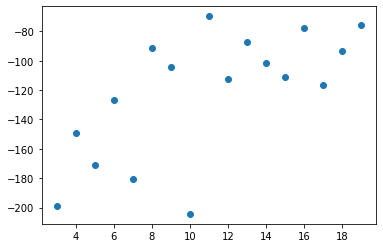

In [47]:
plt.scatter(range(3,20), np.diff(wss))

This plot seems to begin flattening around 10- or 11-clusters. Thus, we will use 10 as our "ideal" number of clusters. 

### Pick Ideal Number of Clusters

Now that we have our "ideal" number of clusters for our data, we can create a new model with `n_clusters = 10` and then fit this model.

In [48]:
model = KMeans(n_clusters = 10, random_state=42, n_jobs = -1)
model.fit(features)

C:\Users\07hoc\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

To get our predicted clusters, we can use the `.predict()` function.

In [49]:
cluster_labels = model.predict(features)

In [50]:
cluster_labels

array([6, 8, 1, ..., 1, 1, 1])

The `np.bincount()` function allows use to count the occurrence of each element (Numpy.bincount in python, 2017). In other words, we can count the number of points our model predicted for each cluster. 

In [63]:
np.bincount(cluster_labels)
#gives number of points in each cluster

array([ 1745, 39220,  2722,  2483,  2122,  1208,  5087,  3110,  1610,
        3510], dtype=int64)

In [155]:
np.bincount(cluster_labels).sum(), len(tweet_df)

(62817, 62817)

## Word Counts for Clusters

We can now view the documents in each cluster.

In [146]:
#get tweets for first cluster (0)

cluster0_tweets = np.array(clean_tweets)[cluster_labels == 0]
cluster1_tweets = np.array(clean_tweets)[cluster_labels == 1]

In [148]:
len(cluster0_tweets), len(cluster1_tweets) #confirm num documents in each cluster

(1745, 39220)

In [149]:
cluster0_tweets

array(['  needle well one', 'well hospital food may become law',
       'british Ebola patient pretty well', ...,
       '  braindamaged vet may get well never well another tour de force  ',
       '  RocheGenentech profit soar well cancer drug  ',
       '  least one measure age risk pool exchange look well risky  '],
      dtype='<U9914')

Looking at the tweets that have been assigned to the first cluster (output above), we can assume tweets containing hospital related topics have been assigned to this cluster. To get a better idea of the information in each cluster, we can find the top word counts in each cluster using the `FreqDist` class in the `NLTK` module. In order to use `nltk.FreqDist`, we need to use the `nltk.tokenize.word_tokenize()` function to return a tokenized copy of our text using NLTK's word tokenizer (Nltk. Tokenize package, n.d.). This tokenizer divides a string into substrings by splitting on a specified string (Nltk. Tokenize package, n.d.). 

In [167]:
wordcount0 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster0_tweets)))
wordcount1 = nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(cluster1_tweets)))

In [170]:
print('Cluster 1 contains',len(wordcount0),'words.\n')
print('Cluster 2 contains',len(wordcount1),'words.')

Cluster 1 contains 3438 words.

Cluster 2 contains 26417 words.


After using `NLTK` to tokenize words and get word counts, we can use the `.most_common()` function to get the top words in the cluster. Below, we find the top 15 words in our first cluster.  

In [158]:
wordcount0.most_common(15)

[('well', 1852),
 ('ask', 109),
 ('May', 87),
 ('get', 77),
 ('risk', 71),
 ('exercise', 64),
 ('think', 60),
 ('make', 59),
 ('live', 59),
 ('find', 57),
 ('doctor', 55),
 ('Cancer', 54),
 ('like', 52),
 ('cancer', 52),
 ('study', 48)]

To get the word counts for all clusters, we can use a loop. We will loop through the range of our clusters (`range(0,10)`). Then, we add our tokenized words for each cluster to a list (`cluster_tweets`). After all the words for all clusters are added, our `cluster_tweets` list will contain a list of words for each cluster (i.e. a list of lists).

In [113]:
cluster_tweets = []

for i in range(0,10):
    cluster_tweets.append(nltk.FreqDist(nltk.tokenize.word_tokenize(' '.join(np.array(clean_tweets)[cluster_labels == i]))))

To ensure our loop was successful, we can compare the size of each list in our `cl.uster_tweets` to our `len(wordcount0)` and `len(wordcount1)` output above

In [171]:
print('List with cluster 1 words contains',len(cluster_tweets[0]),'words.\n')
print('List with cluster 2 words contains',len(cluster_tweets[1]),'words.')

List with cluster 1 words contains 3438 words.

List with cluster 2 words contains 26417 words.


### Most Common Words in Each Cluster

Now, we can loop through our "list of lists" and print out the most common words for each cluster. 

In [163]:
for i in range(0,10):
    print('Cluster', i+1,'-', cluster_tweets[i].most_common(15), '\n')

Cluster 1 - [('well', 1852), ('ask', 109), ('May', 87), ('get', 77), ('risk', 71), ('exercise', 64), ('think', 60), ('make', 59), ('live', 59), ('find', 57), ('doctor', 55), ('Cancer', 54), ('like', 52), ('cancer', 52), ('study', 48)] 

Cluster 2 - [('Health', 1339), ('make', 1273), ('find', 1168), ('food', 1159), ('help', 1143), ('study', 1104), ('US', 1027), ('amp', 991), ('good', 938), ('via', 886), ('risk', 851), ('eat', 840), ('try', 833), ('one', 813), ('¦', 813)] 

Cluster 3 - [('say', 2761), ('study', 369), ('US', 140), ('new', 138), ('expert', 135), ('CDC', 130), ('doctor', 120), ('may', 120), ('risk', 96), ('report', 96), ('need', 93), ('Study', 88), ('drug', 78), ('cancer', 77), ('make', 75)] 

Cluster 4 - [('get', 2565), ('help', 133), ('food', 106), ('tip', 96), ('new', 86), ('start', 86), ('one', 85), ('like', 82), ('healthy', 81), ('good', 79), ('say', 78), ('patient', 74), ('time', 74), ('amp', 72), ('woman', 71)] 

Cluster 5 - [('patient', 1196), ('doctor', 1054), ('ho

The output above allows us to make better assumptions about the content in each cluster. For example, our first assumption about Cluster 1 was that hospital related topics were placed there. Looking at the most common words above, we can confirm that assumption by the key words 'risk', 'exercise', 'cancer', 'doctor', and 'study'. It appears that Cluster 6 is about healthy eating, which is indicated by the key words 'healthy', 'calorie', 'weight', and 'eat'. We can assume that Cluster 9 contains documents that discuss affordable health care. This is indicated by the key words 'Affordable', 'Care', 'care', 'cost', and 'need'. 

### Cluster 6 WordCloud

Another technique to determine the content of our clusters is to produce a WordCloud of the words in the cluster. As an example, the words in our 6th Cluster will be used to create a WordCloud. 

In [132]:
import wordcloud
import matplotlib.pyplot as plt

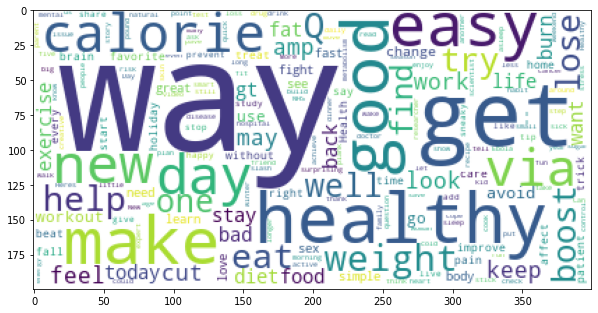

In [165]:
fig = plt.figure(figsize=(10, 10))
wc = wordcloud.WordCloud(background_color ="white")
plt.imshow(wc.generate_from_frequencies(dict(cluster_tweets[5])))
#Sometimes cell needs to be run twice 

The purpose of this assignment was to cluster tweets on healthcare news using the K-means clustering algorithm. We began by reading all the healthcare news documents using `iglob()` and then we added them to a list. Then, we used the `pd.concat()` function to combine all the documents into a single dataframe. We then used a new text cleaning function and other various text cleaning techniques on our dataframe to lemmatize words, lowercase words, remove stopwords, remove punctuation, and remove any other unnecessary strings (like weblinks, usernames, and hashtags). After cleaning our text, we created TfIdf vectors (features) for the documents and then we used the K-means clustering algorithm to cluster the documents. To choose the optimal number of clusters, we used the `within sum of squares` scoring metric. While there wasn't a clear number of optimal clusters, we were able to choose a reasonable number for the number of clusters. Finally, we used the `NLTK` library to look at the highest wordcount words in each cluster and create a WordCloud.  

# Resources

Arora, L. (2020, February 14). Loc vs. Iloc in pandas for selecting data. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/02/loc-iloc-pandas/

Cluster. Kmeans. (n.d.). Retrieved June 7, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Combining datasets. (n.d.). Retrieved June 7, 2020, from https://jakevdp.github.io/PythonDataScienceHandbook/03.06-concat-and-append.html

Dabbura, I. (2020, April 29). K-means clustering: Algorithm, applications, evaluation methods, and drawbacks. Medium. https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a

Feature_extraction. Text. Tfidfvectorizer. (n.d.). Retrieved June 7, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Garbade, D. M. J. (2018, September 12). Understanding k-means clustering in machine learning. Medium. https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

How to use Glob() function. (2019, December 31). GeeksforGeeks. https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/

Karami, A. (2017). Uci machine learning repository: Health news in twitter data set. https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter#

Nltk. Tokenize package. (n.d.). Retrieved June 7, 2020, from https://www.nltk.org/api/nltk.tokenize.html

Numpy.bincount in python. (2017, October 2). GeeksforGeeks. https://www.geeksforgeeks.org/numpy-bincount-python/

Numpy.diff in python. (2019, September 23). GeeksforGeeks. https://www.geeksforgeeks.org/numpy-diff-in-python/

Python time Module . (n.d.). Retrieved June 7, 2020, from https://www.programiz.com/python-programming/time

Selecting number of clusters. (n.d.). Retrieved June 7, 2020, from https://campus.datacamp.com/courses/unsupervised-learning-in-r/unsupervised-learning-in-r?ex=9

Set() method. (2018, October 3). GeeksforGeeks. https://www.geeksforgeeks.org/python-set-method/